In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from scipy.stats import mannwhitneyu
from pathlib import Path

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

In [3]:
base_path = Path("data")
all_folders = base_path.glob("*pts*")

# Now in each folder for each pkl file open the observation list
# From the observation list get obs_list[-1]["fly"][0] the last fly position
# Generate a scatter plot for each condition with the last fly z position¨
# Chnage the color if the adhesion is on
# Save the figure in the base directory
kp_selector = "_kp30.0"

save_path = Path(f"outputs/panel{kp_selector}_noadh.pdf")

controller = ["CPG", "Decentralized", "hybrid"]
terrain = ["flat", "blocks", "gapped", "mixed"]
adhesion = [True]

conditions = [(c, t) for t in terrain for c in controller]
n_conditions = len(conditions)

sim_time = 1.2
init_time = 0.2
all_rows = []
all_colors = np.tile(["r", "b"], n_conditions)

for controller, terrain in conditions:
    for adh in adhesion:
        path = base_path / f"{terrain}_{controller}pts_adhesion{adh}{kp_selector}"
        if not path.is_dir():
            print(f"Path {path} does not exist")
            continue
        all_pkl = list(path.glob("*.pkl"))
        assert len(all_pkl) > 1, f"Path {path} does not contain any pkl file"
        data_pts = []
        for pkl_file in all_pkl:
            with open(pkl_file, "rb") as f:
                obs_list = pickle.load(f)
            assert len(obs_list) == sim_time * 10_000
            distance = obs_list[-1]["fly"][0][0] - obs_list[0]["fly"][0][0]
            speed = distance / (sim_time - init_time)
            all_rows.append([controller.lower(), terrain.lower(), adh, speed])

speed_df = pd.DataFrame(
    all_rows, columns=["controller", "terrain", "adhesion", "speed"]
)
speed_df.to_csv("outputs/mean_speed.csv", index=False)

In [4]:
speed_df.iloc[40]

controller      hybrid
terrain           flat
adhesion          True
speed         9.020784
Name: 40, dtype: object

In [5]:
speed_df_norm = speed_df.copy()
for controller in ["cpg", "decentralized", "hybrid"]:
    full_speed = speed_df[(speed_df["controller"] == controller) & (speed_df["terrain"] == "flat")]["speed"].mean()
    speed_df_norm.loc[speed_df_norm["controller"] == controller, "speed"] /= full_speed

In [6]:
print(
    speed_df[speed_df["terrain"] == "flat"]["speed"].min(),
    speed_df[speed_df["terrain"] == "flat"]["speed"].max(),
)
print(
    speed_df_norm[speed_df_norm["terrain"] != "flat"]["speed"].min(),
    speed_df_norm[speed_df_norm["terrain"] != "flat"]["speed"].max(),
)

6.573401917525386 9.399192582313566
-0.1279687214017262 1.1254363071893827


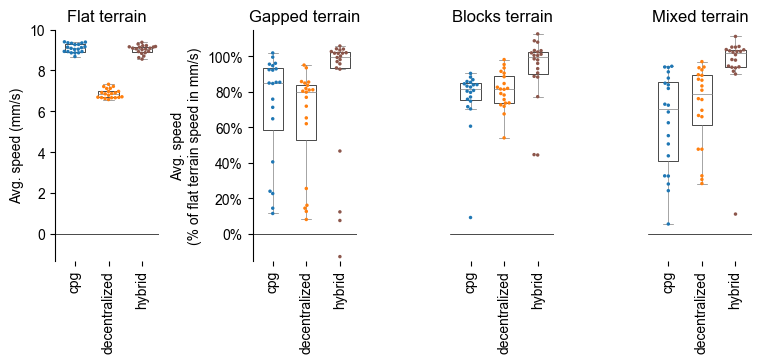

In [7]:
x_pos_lookup = {
    ("cpg", "flat"): 0,
    ("decentralized", "flat"): 1,
    ("hybrid", "flat"): 2,
    ("cpg", "gapped"): 5,
    ("decentralized", "gapped"): 6,
    ("hybrid", "gapped"): 7,
    ("cpg", "blocks"): 10,
    ("decentralized", "blocks"): 11,
    ("hybrid", "blocks"): 12,
    ("cpg", "mixed"): 15,
    ("decentralized", "mixed"): 16,
    ("hybrid", "mixed"): 17,
}
colors_lookup = {
    "cpg": "tab:blue",
    "decentralized": "tab:orange",
    "hybrid": "tab:brown",
}

fig, axs = plt.subplots(1, 4, figsize=(9, 3))
plt.subplots_adjust(wspace=0.9)
for i, terrain_type in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    ax.set_title(f"{terrain_type.title()} terrain")

    df = speed_df if terrain_type == "flat" else speed_df_norm
    ylim = [-0.15 * 10 / 1.15, 10] if terrain_type == "flat" else [-0.15, 1.15]

    boxplot = sns.boxplot(
        x="controller",
        y="speed",
        data=df[df["terrain"] == terrain_type],
        width=0.6,
        ax=ax,
        showfliers=False,
        boxprops={"facecolor": "None", "edgecolor": "k", "linewidth": 0.5},
        medianprops={"color": "gray", "linewidth": 0.5},
        whiskerprops={"color": "gray", "linewidth": 0.5},
        capprops={"color": "gray", "linewidth": 0.5},
    )
    sns.swarmplot(
        x="controller",
        y="speed",
        data=df[speed_df_norm["terrain"] == terrain_type],
        hue="controller",
        size=2.5,
        palette=["tab:blue", "tab:orange", "tab:brown"],
        ax=ax,
        legend=False,
    )
    ax.set_xlim(-0.6, 2.5)
    ax.set_ylim(ylim)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.axhline(0.0, color="k", linewidth=0.5)
    if terrain_type not in ["flat", "gapped"]:
        ax.set_ylabel("")
        ax.set_yticks([])
    if terrain_type == "flat":
        ax.set_ylabel("Avg. speed (mm/s)")
    elif terrain_type == "gapped":
        ax.set_ylabel("Avg. speed\n(% of flat terrain speed in mm/s)")
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
    ax.set_xlabel("")
    sns.despine(ax=ax, bottom=True, left=terrain_type not in ["flat", "gapped"])

plt.savefig("outputs/speed_comparison.pdf", transparent=True)

In [8]:
for variable, df in [("Absolute speed", speed_df), ("Normalized speed", speed_df_norm)]:
    for terrain_type in ["flat", "gapped", "blocks", "mixed"]:
        hybrid_pts = df[
            (df["controller"] == "hybrid") & (df["terrain"] == terrain_type)
        ]["speed"].values
        for controller in ["cpg", "decentralized"]:
            my_pts = df[
                (df["controller"] == controller) & (df["terrain"] == terrain_type)
            ]["speed"].values
            u, p = mannwhitneyu(
                my_pts, hybrid_pts, alternative="less", method="asymptotic"
            )
            print(f"{variable} - {terrain_type} - {controller} vs hybrid: {p:.6f}")

Absolute speed - flat - cpg vs hybrid: 0.802915
Absolute speed - flat - decentralized vs hybrid: 0.000000
Absolute speed - gapped - cpg vs hybrid: 0.005291
Absolute speed - gapped - decentralized vs hybrid: 0.000230
Absolute speed - blocks - cpg vs hybrid: 0.000058
Absolute speed - blocks - decentralized vs hybrid: 0.000006
Absolute speed - mixed - cpg vs hybrid: 0.000007
Absolute speed - mixed - decentralized vs hybrid: 0.000001
Normalized speed - flat - cpg vs hybrid: 0.462286
Normalized speed - flat - decentralized vs hybrid: 0.347446
Normalized speed - gapped - cpg vs hybrid: 0.003020
Normalized speed - gapped - decentralized vs hybrid: 0.000507
Normalized speed - blocks - cpg vs hybrid: 0.000037
Normalized speed - blocks - decentralized vs hybrid: 0.000311
Normalized speed - mixed - cpg vs hybrid: 0.000003
Normalized speed - mixed - decentralized vs hybrid: 0.000004
